Bank Customers Churn14

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

label_size = 17

plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = label_size - 2

random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

print ('Libraries Loaded!')

Libraries Loaded!


In [2]:
def plot_continuous(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    
    sns.distplot(df_remained[feature], bins = 15, color = colors[0], label = 'Remained', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    sns.distplot(df_churned[feature], bins = 15, color = colors[1], label = 'Churned', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    ax1.set_title('{} distribution - Histogram'.format(feature))
    ax1.set_ylabel('Counts')
    ax1.legend()

    sns.boxplot(x = 'Exited', y = feature, data = train_df, palette = colors, ax = ax2)
    ax2.set_title('{} distribution - Box plot'.format(feature))
    ax2.set_xlabel('Status')
    ax2.set_xticklabels(['Remained', 'Churned'])

    plt.tight_layout();
    
    
def plot_categorical(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    sns.countplot(x = feature, hue = 'Exited', data = train_df, palette = colors, ax = ax1)
    ax1.set_ylabel('Counts')
    ax1.legend(labels = ['Retained', 'Churned'])
    
    sns.barplot(x = feature, y = 'Exited', data = train_df, palette = colors2 , ci = None, ax = ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    
    plt.tight_layout();
    
def plot_learning_curve(estimator, estimator_name, X, y, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):
                 
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes, scoring = 'accuracy')
    
    train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'dodgerblue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'darkorange')
    
    plt.plot(train_sizes, train_scores_mean, color = 'dodgerblue', marker = 'o', linestyle = '-', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, color = 'darkorange', marker = 'o', linestyle = '-', label = 'Cross-validation Score')
    plt.title(estimator_name)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc = 'best')
            
    plt.tight_layout();
    
def plot_conf_mx(cm, classifier_name, ax):
    sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 24}, ax = ax)
    ax.set_title('{}'.format(classifier_name))
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Remained', 'Churned'])
    ax.set_ylabel('True Label') 
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Remained', 'Churned']);
    
def plot_feature_imp(classifier, classifier_name, color, ax):

    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

    importances.plot.barh(color = color, edgecolor = 'firebrick', legend = False, ax = ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');
    
def clf_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items() :
        print ('      {}: {}'.format(key, value))
    
    y_pred_pp = cross_val_predict(classifier.best_estimator_, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    
    cm = confusion_matrix(y_train, y_pred, normalize = 'true')
    
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    
    comparison_dict[classifier_name_abv] = [accuracy_score(y_train, y_pred), 
                                            precision_score(y_train, y_pred),
                                            recall_score(y_train, y_pred),
                                            roc_auc_score(y_train, y_pred_pp),
                                            fpr, tpr]    

    fig, ax = plt.subplots(figsize = (5, 4))
    
    plot_conf_mx(cm, '', ax)    
    plt.tight_layout();
    
def test_func(classifier, classifier_name):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    
    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred), 
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    
    plt.title(classifier_name)
    sns.heatmap(cm, annot = True, annot_kws = {'fontsize': 18}, cmap = 'Blues')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Remained', 'Churned'])
    plt.ylabel('True Label') 
    plt.yticks([0.2, 1.4], ['Remained', 'Churned']);
    
print ('Functions defined!')

Functions defined!


In [3]:
df = pd.read_csv("D:/Medium/3 Learned/Bank Customers Churn/Churn Modeling.csv")

print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our dataframe has 14 features and 10K customers/instances. The last feature, 'Exited', is the target variable and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


there are no missing values in our dataset. Columns 'RowNumber', 'CustomerID' and 'Surname' are specific to each customer and can be dropped:

In [5]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:

    The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
    The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3), and
    Approximately 50% of customers are active.


Creating a Test Set

In [7]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

print('Shape')
print('Train set: {} rows x {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0], test_df.shape[1]))

Shape
Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


As we mentioned earlier, our target variable is already encoded:

    Exited = 0, for non-churned customers, and
    Exited = 1, for churned customers.


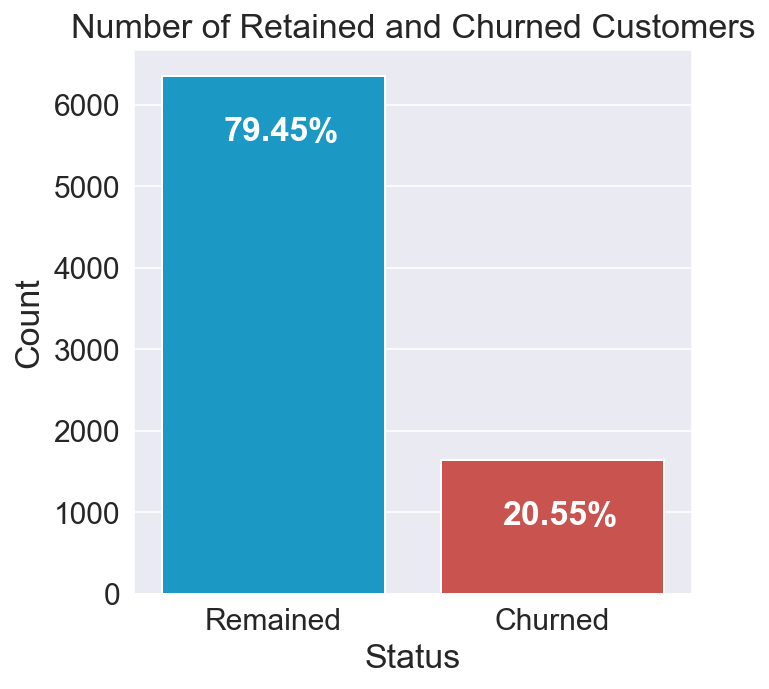

In [8]:
colors = ['#00A5E0', '#DD403A']

fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'Exited', data = train_df, palette = colors)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label =  '{}%'.format(round( (value/train_df['Exited'].shape[0])*100, 2)) 
    plt.annotate(label, xy = (index - 0.18, value - 800), color = 'w', fontweight = 'bold', size = label_size)

plt.title('Number of Retained and Churned Customers')
plt.xticks([0, 1], ['Remained', 'Churned'])
plt.xlabel('Status')
plt.ylabel('Count');

The bank kept 80% of its clientele.

Notice that our dataset is skewed/imbalanced since the number of instances in the 'Remained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.


Continuous Variables

By calling the hist() method we can plot a histogram for each of the four continuous numeric features:


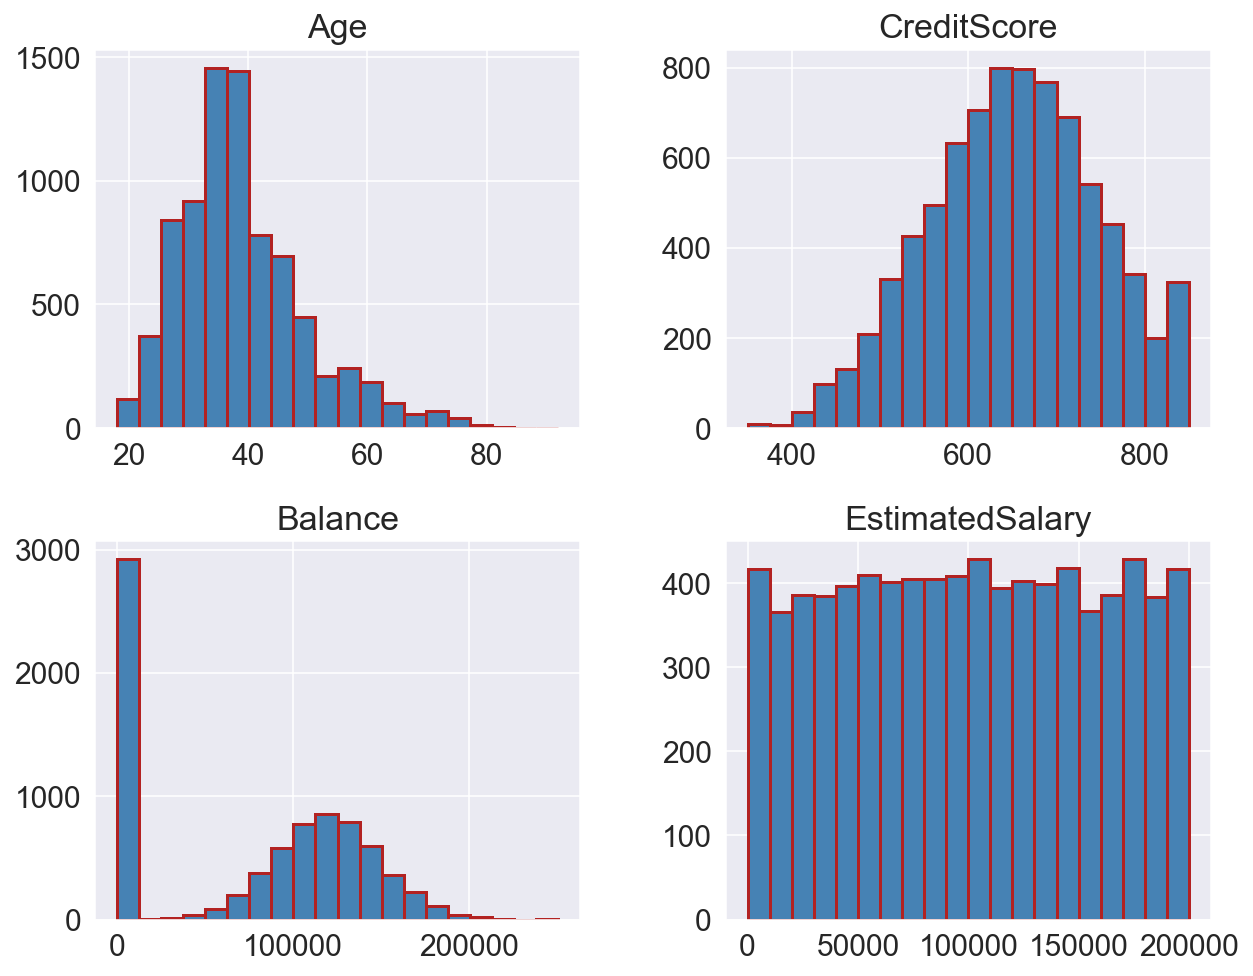

In [9]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
train_df[continuous].hist(figsize = (10, 8), bins = 20, layout = (2, 2), 
                          color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5);

Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
Most values for 'CreditScore' are above 600,
If we ignore the fist bin, 'Balance' follows a fairly normal distribution, and
The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

Looking for Correlations

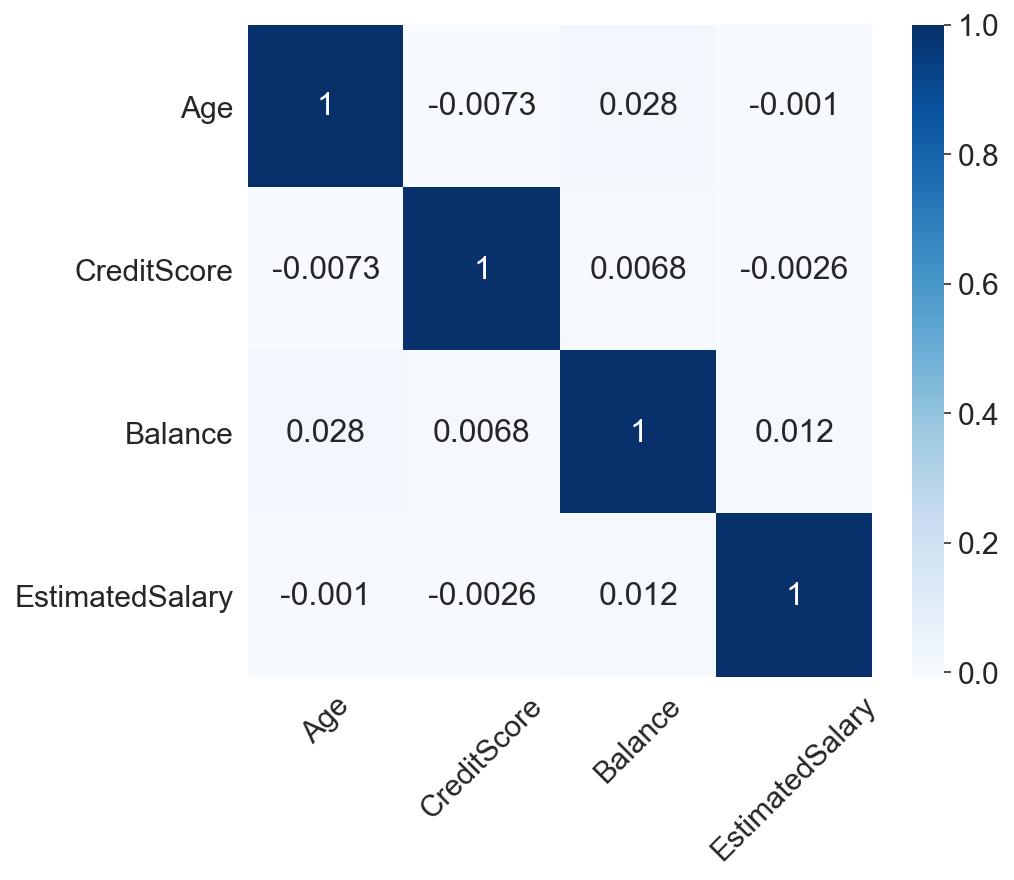

In [10]:
plt.figure(figsize = (7, 6))
ax = sns.heatmap(train_df[continuous].corr(), annot = True, annot_kws = {'fontsize': 16}, cmap = 'Blues')

ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 360);

There is no significant intercorrelation between our features, so we do not have to worry about multicollinearity

Age

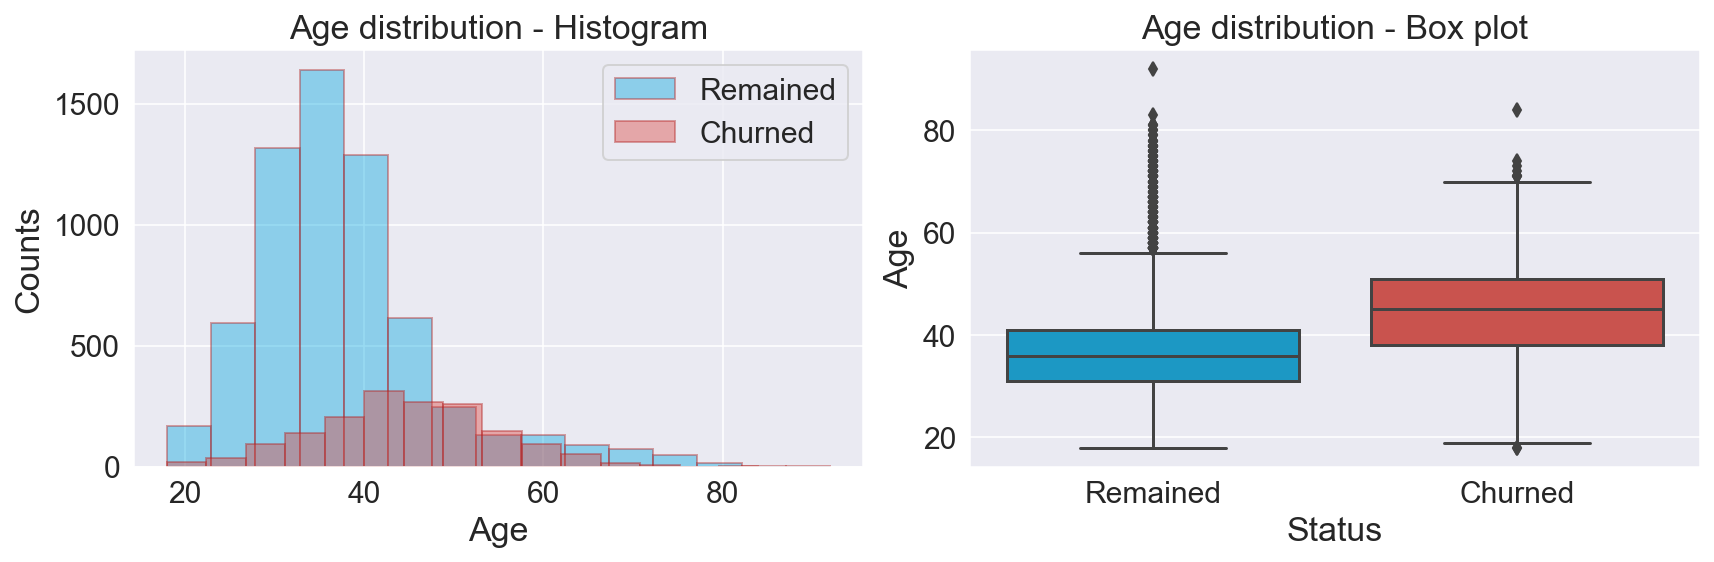

In [11]:
df_churned = train_df[train_df['Exited'] == 1]
df_remained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

Interestingly, there is a clear difference between age groups since older customers are more likely to churn. This could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

Credit Score

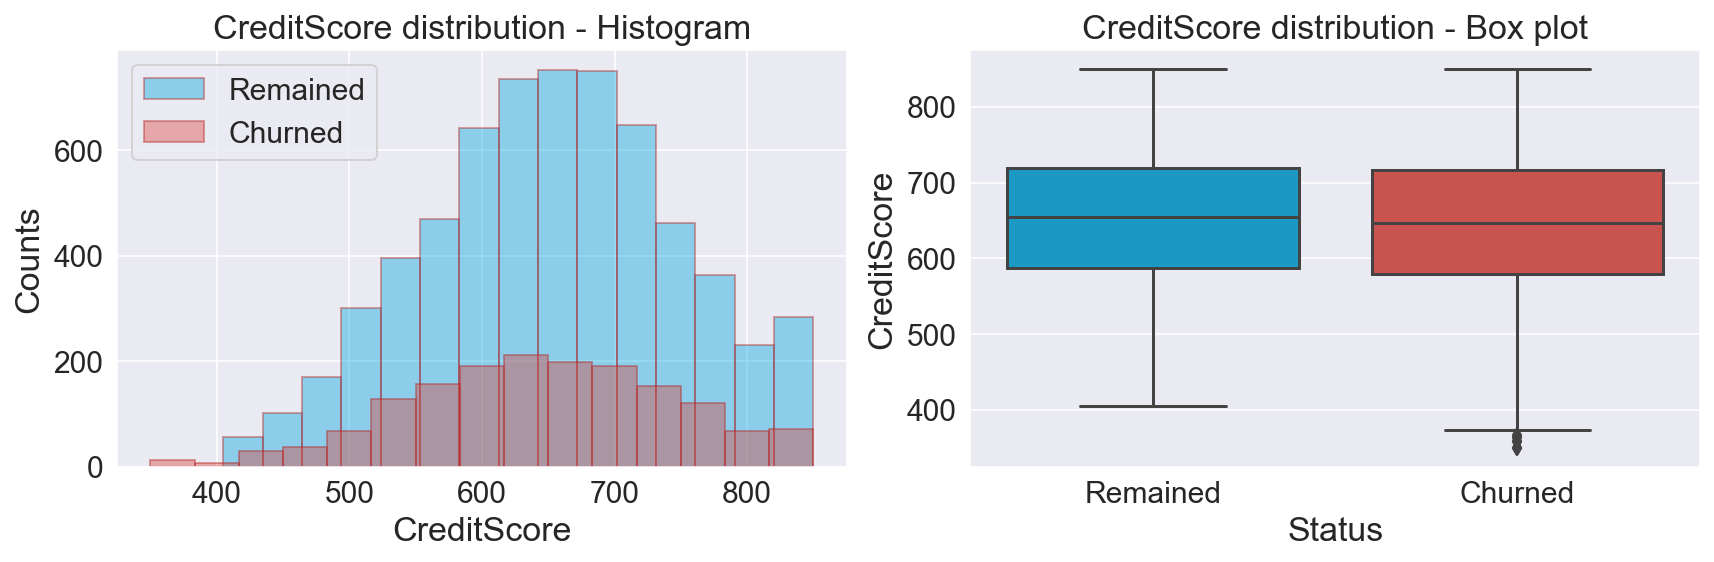

In [12]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit score.

Balance

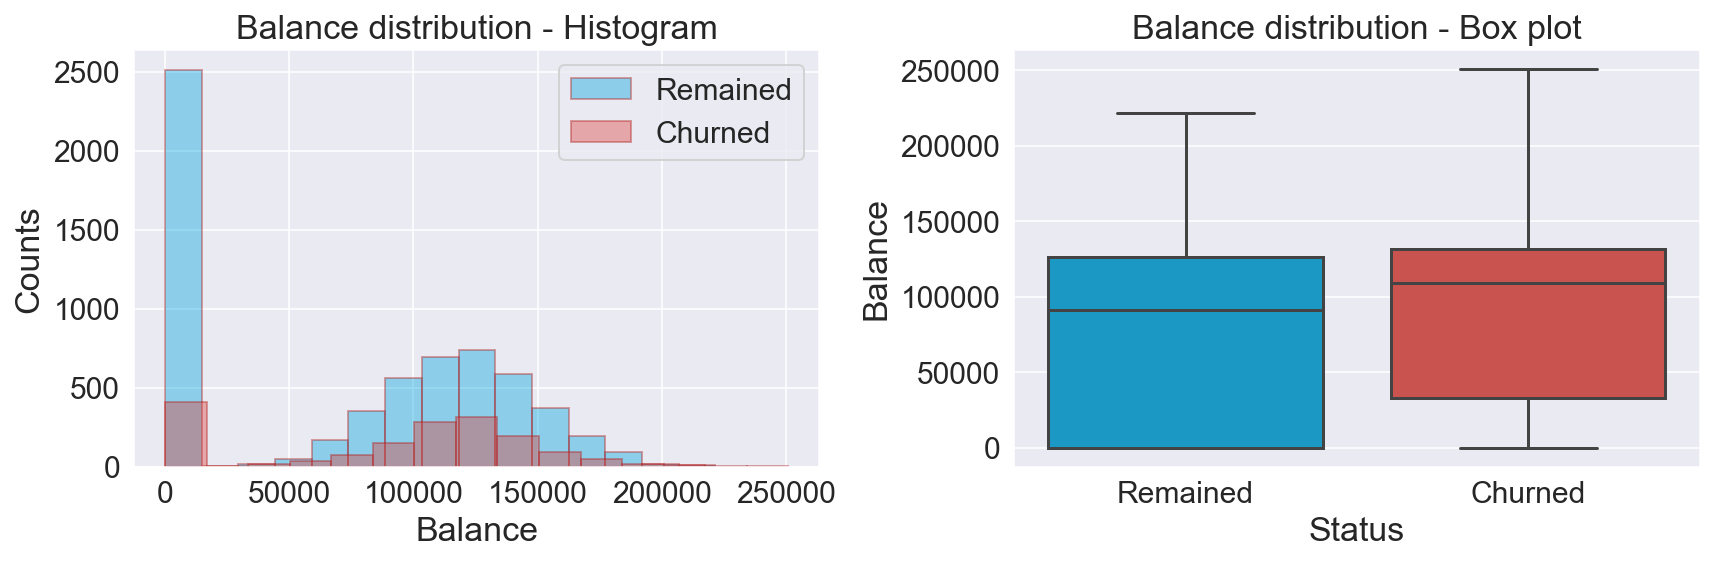

In [13]:
plot_continuous('Balance')

the two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.

Estimated Salary

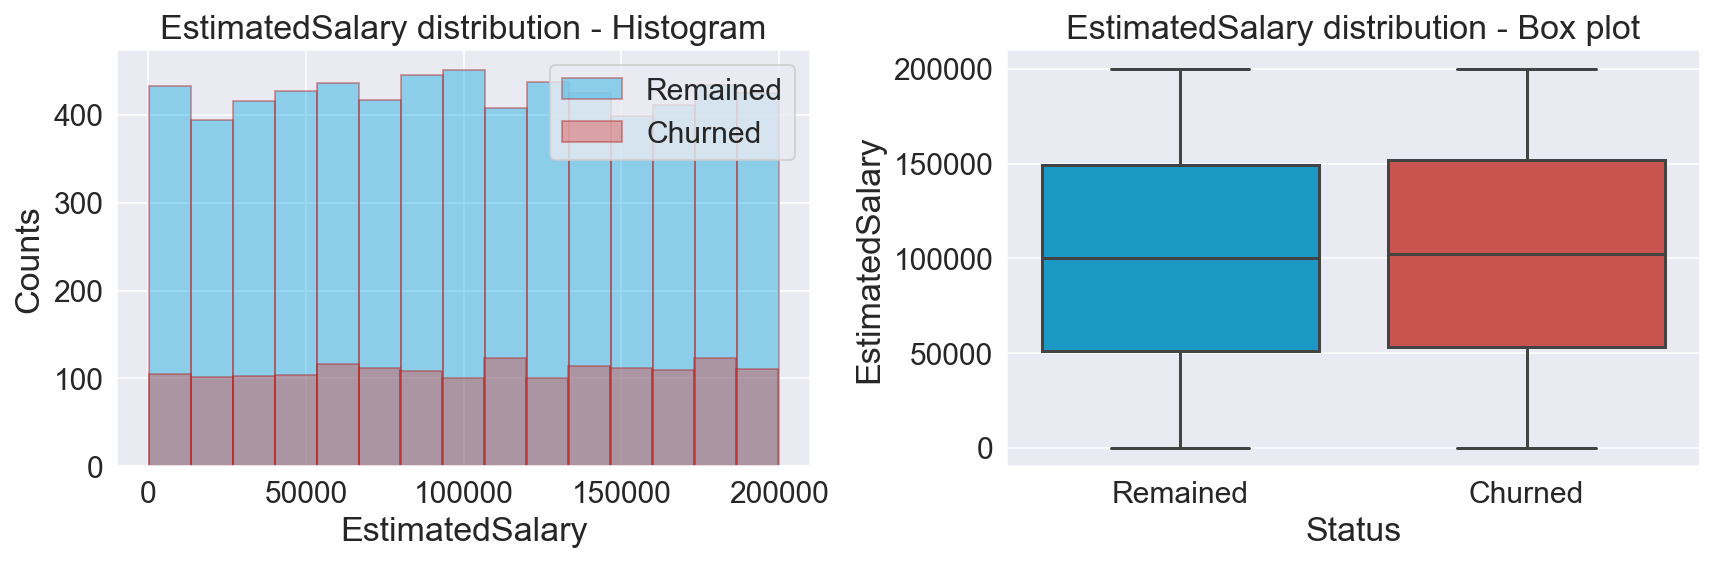

In [14]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution for their salary. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.

Categorical Variables

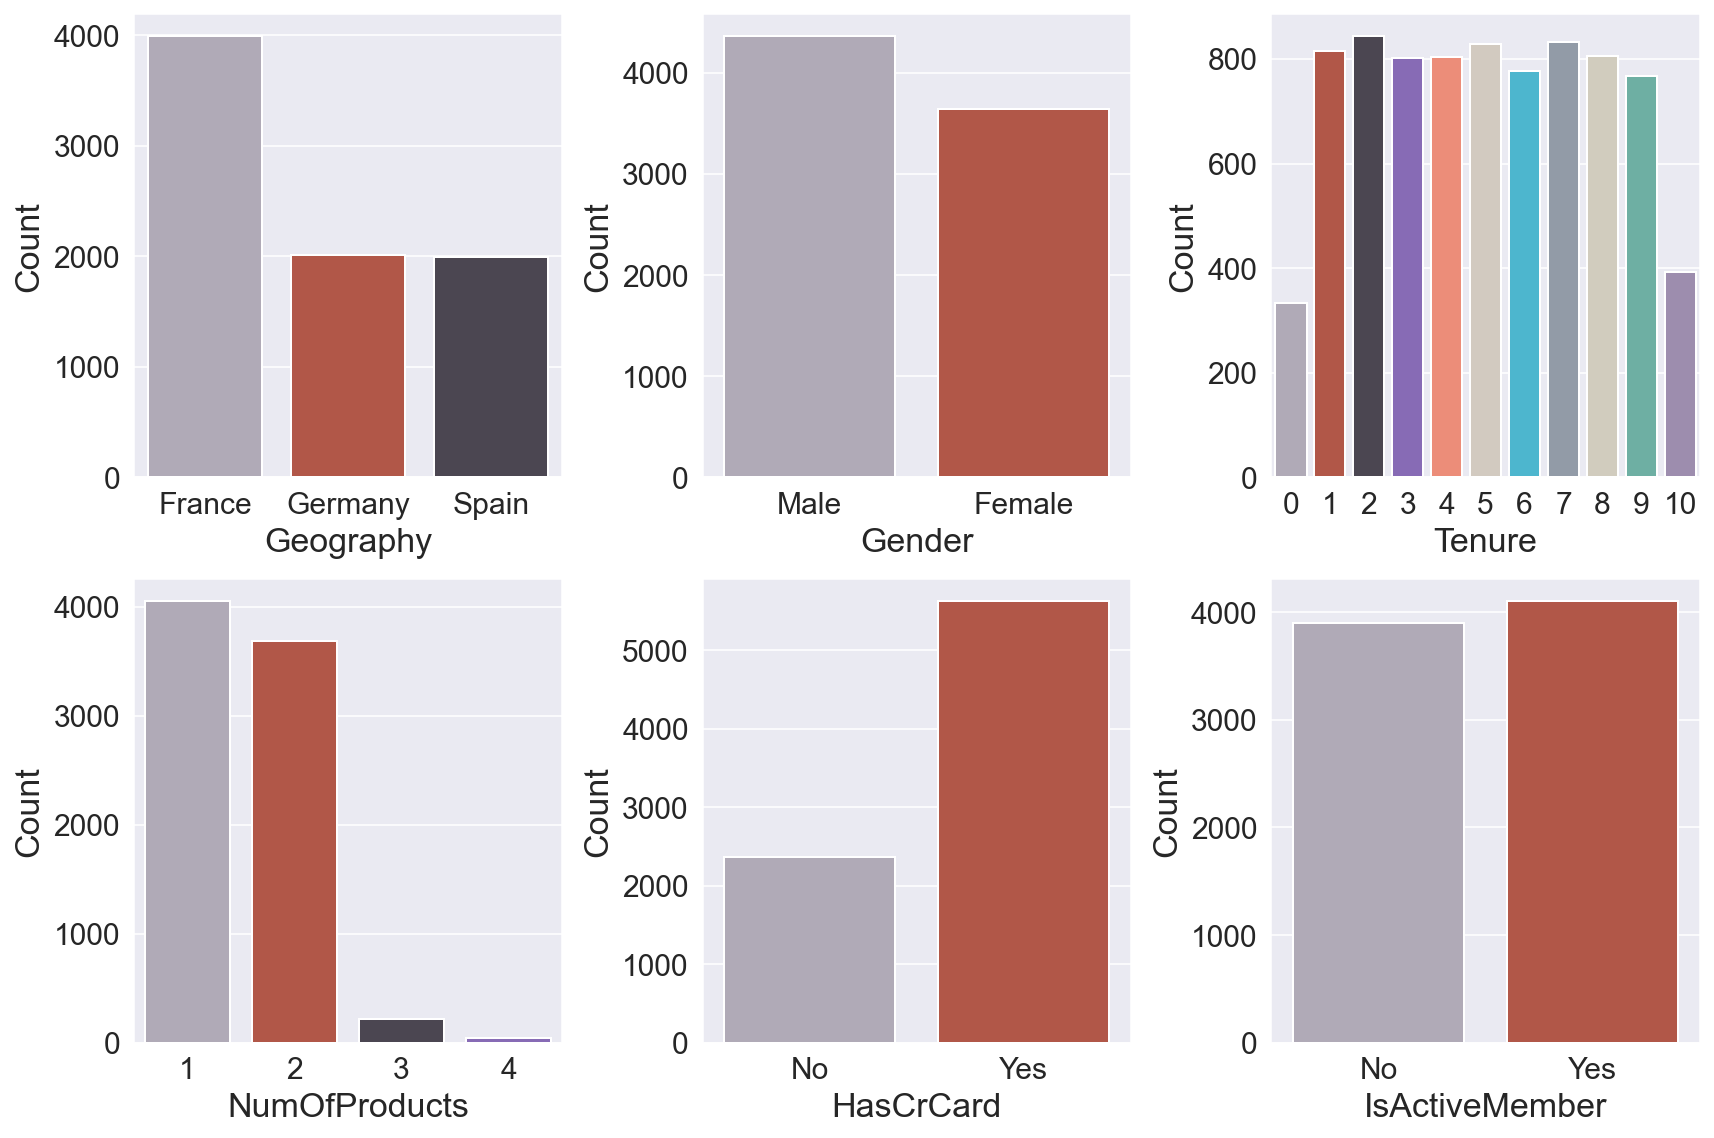

In [15]:
colors2 = ['#B0A8B9', '#C34A36', '#4B4453', '#845EC2', '#FF8066', '#D5CABD', '#38c4e3', '#8f9aaa', '#d4cebb',  '#63BAAA', '#9D88B3']

cat_vars = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_cat = train_df[cat_vars]

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x = column, data = train_df, palette = colors2)
    
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'): 
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

    The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
    There are more male customers than females,
    Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
    Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
    A significant majority of customers has a credit card, and
    Almost 50% of customers are not active.


Geography

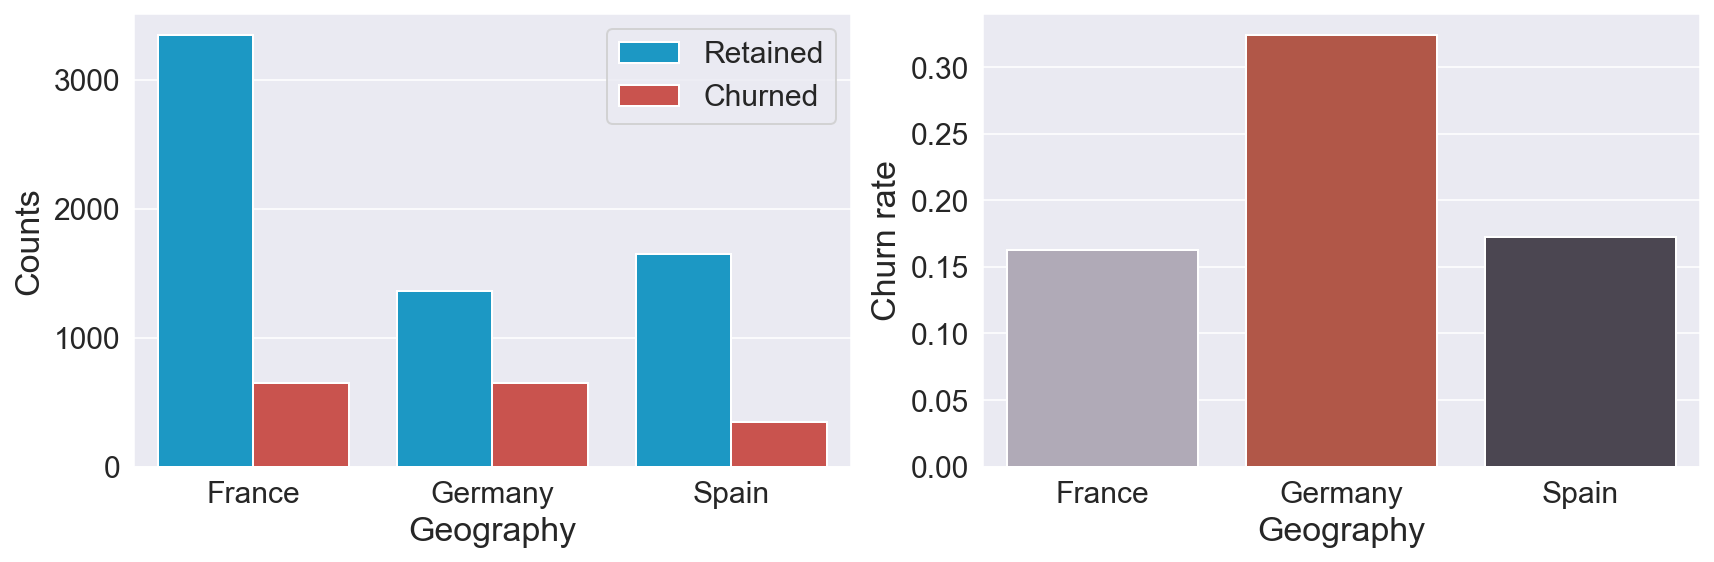

In [16]:
plot_categorical('Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding such as higher competition or different preferences for German customers.

Gender

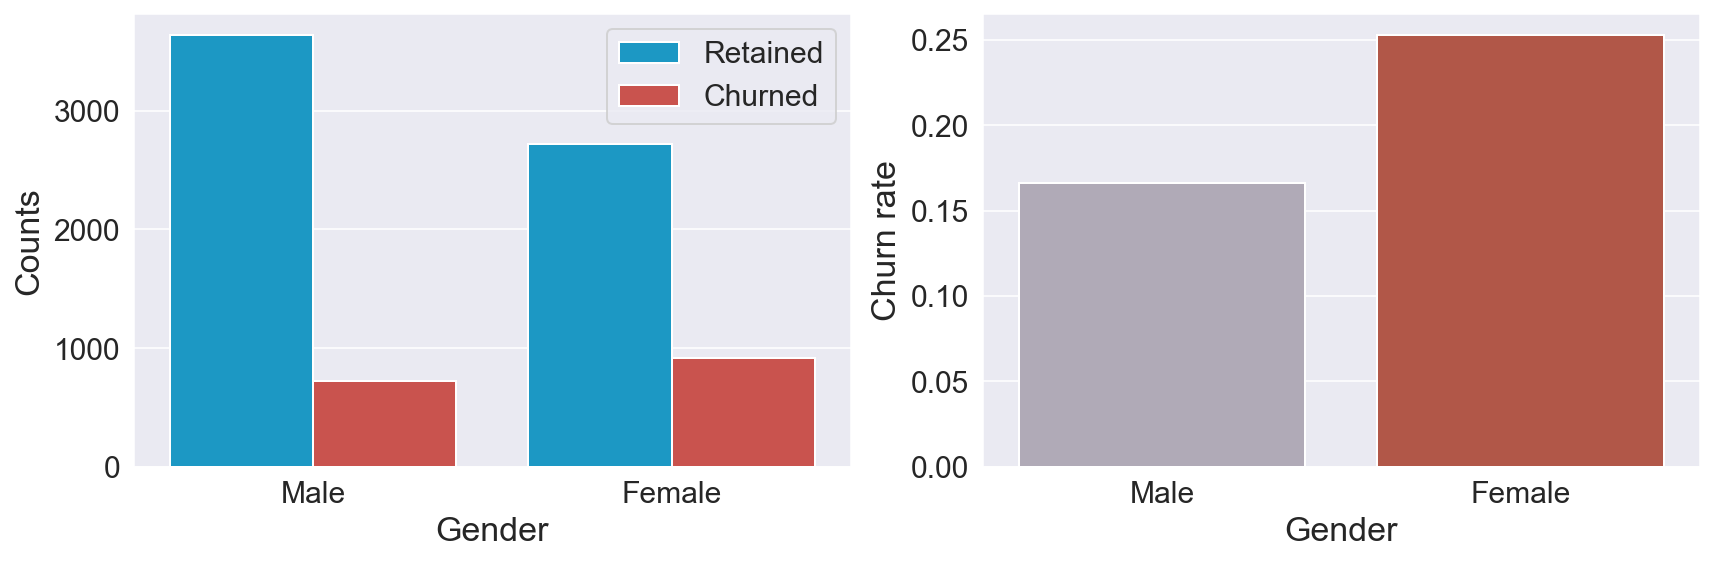

In [17]:
plot_categorical('Gender')

Female customers are more likely to churn.

Tenure

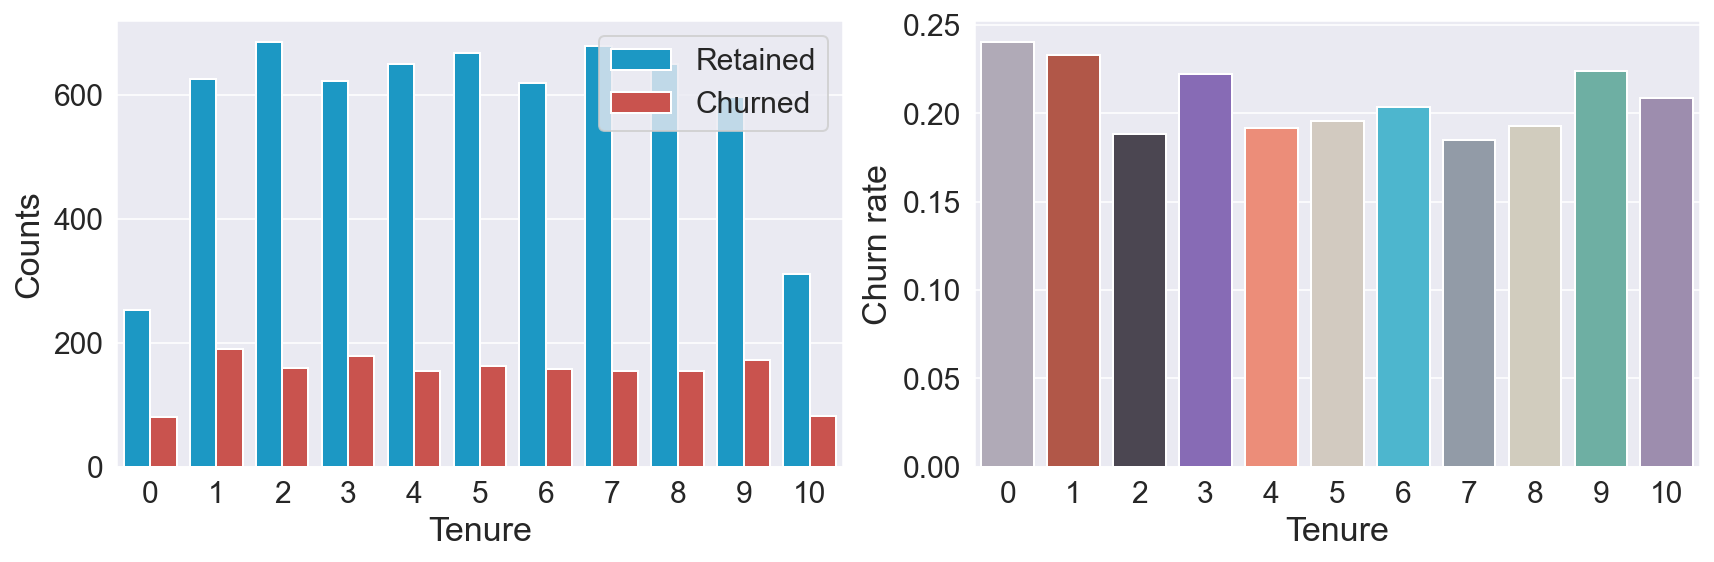

In [18]:
plot_categorical('Tenure')

The number of years (tenure) doesn't seem to affect the churn rate.

Number of Products

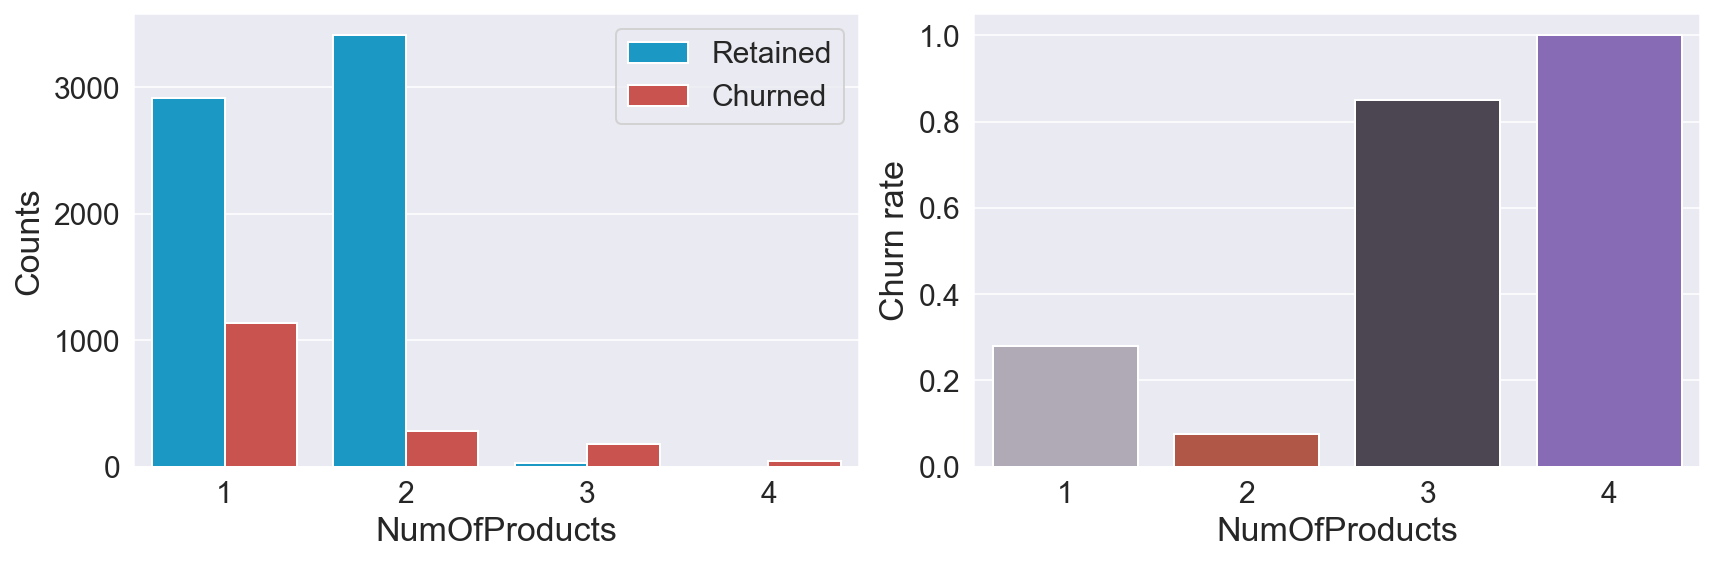

In [19]:
plot_categorical('NumOfProducts')

Interestingly, having 3 or 4 products significantly increases the likelihood of churn. I not sure how to interpret this result. It could potentially mean that the bank is unable to properly support customers with more products which in turn increases customer dissatisfaction.

Card Holders

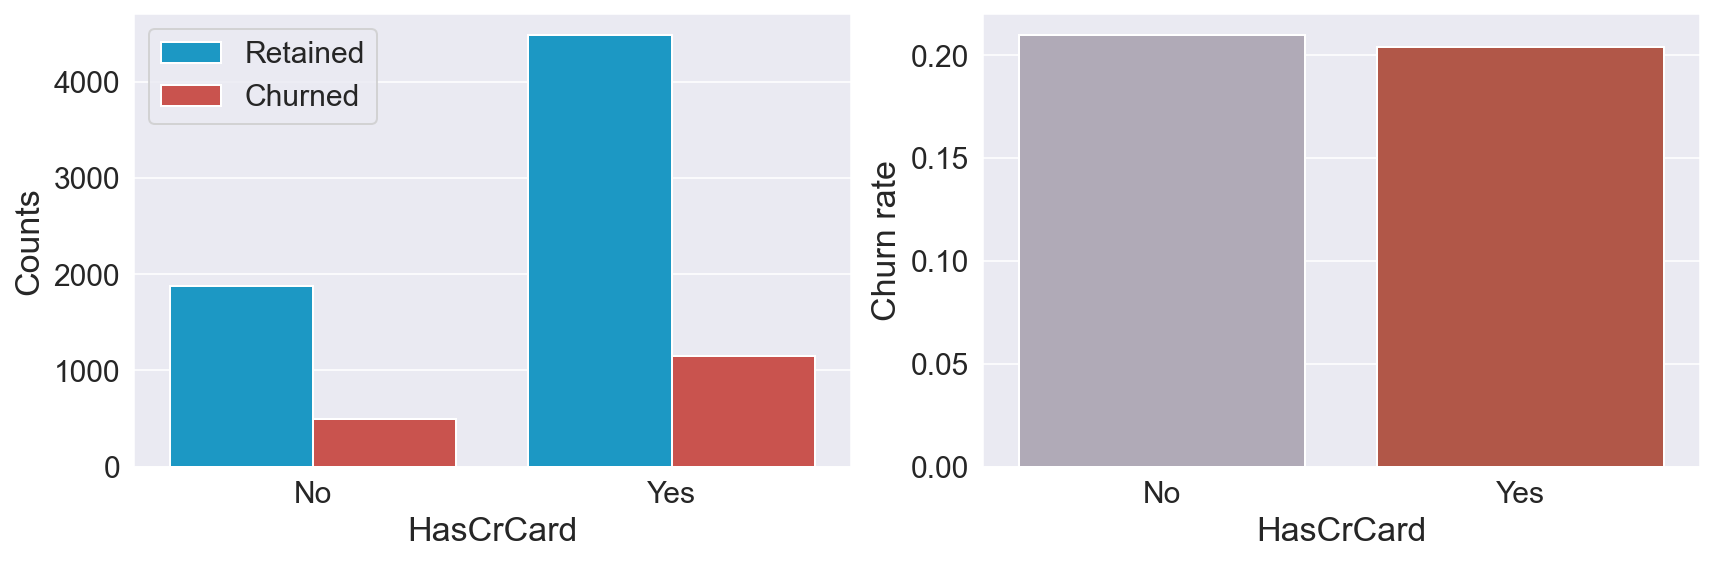

In [20]:
plot_categorical('HasCrCard')

Having a credit card doesn't seem to affect the churn rate.

Active Members

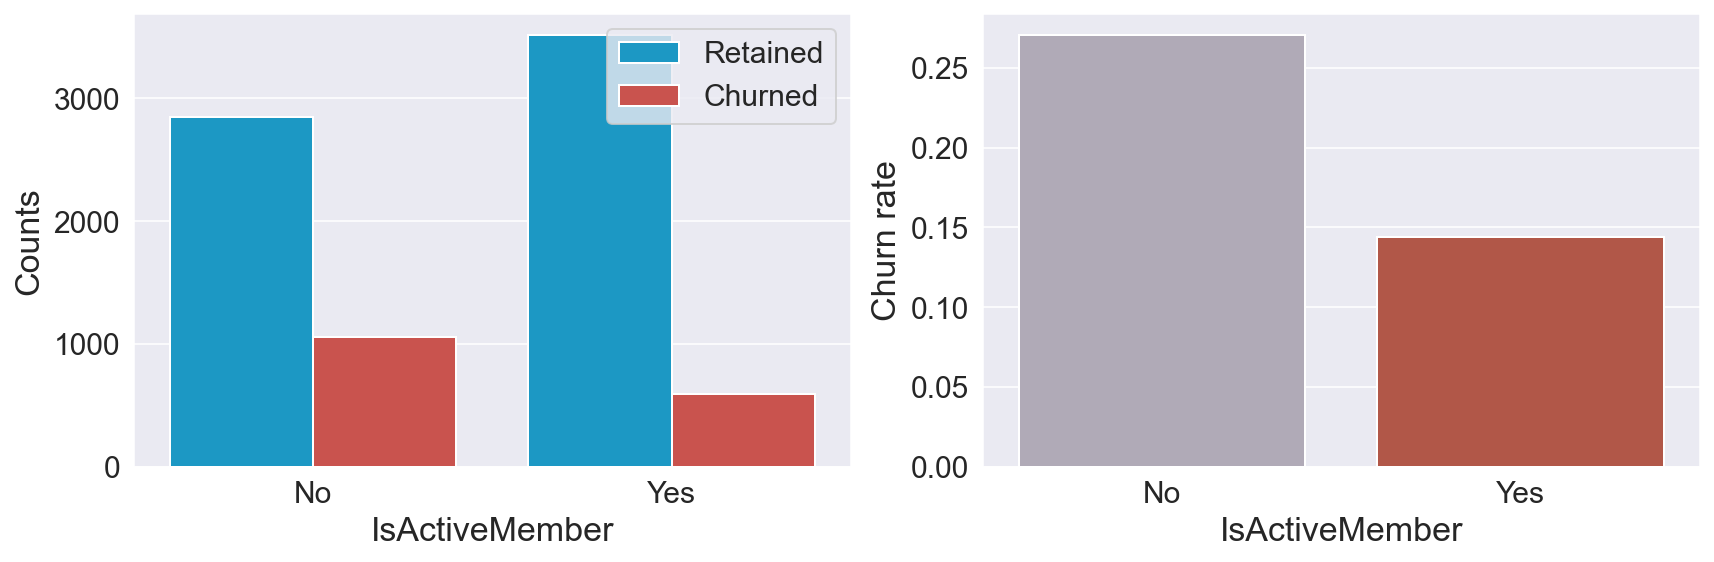

In [21]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A big portion of the clientele is inactive; therefore, the bank will definitely benefit from changing its policy so that more customers become active.

Feature Selection

EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This can be confirmed from a chi-square test [2]:

In [22]:
chi2_array, p_array = [], []
for column in cat_vars:
    
    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({'Variable': cat_vars, 
                       'Chi-square': chi2_array, 
                       'p-value': p_array})
df_chi.sort_values(by = 'Chi-square', ascending = False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595,3.767e-267
0,Geography,230.748,7.829e-51
5,IsActiveMember,195.315,2.199e-44
1,Gender,90.173,2.183e-21
2,Tenure,15.197,1.250e-01
4,HasCrCard,0.301,5.833e-01


Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05 (the standard cut-off value), which confirms our initial hypothesis that these two features do not convey any useful information.

We can use the drop() method to remove these three features from the train set:

In [23]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df.drop(features_drop, axis = 1, inplace = True) 

print ('Features dropped!')

Features dropped!


Our dataset contains two features that require encoding.

    For 'Gender', we will use scikit-learn's LabelEncoder() which maps each unique label to an integer (Male --> 1 and Female --> 0).
    For 'Geography', we will manually map values so that customers in Germany have the value of 1 and all other customers (France and Spain) have zero. I chose this method since the churn rate for customers in the other two countries is almost equal and considerably lower than in Germany. Therefore, it makes sense to encode this feature so that it differentiates between German and non-German customers. Additionally, I tried one-hot encoding (get_dummies()) this feature, and the two new features for France and Spain had small feature importance.


In [24]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({'Germany': 1, 'Spain': 0, 'France': 0})

print ('Features encoded!')

Features encoded!


Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs) while others are invariant to it (e.g. Random Forests).

In [25]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print ('Features scaled!')

Features scaled!


we will split the train set into 'X_train' and 'y_train' sets:

In [26]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print ('Sets created!')

Sets created!


Addressing Class Imbalance

In [27]:
before_sm = Counter(y_train)
print(before_sm)

Counter({0: 6356, 1: 1644})


Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favor of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. Additionally, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.01% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

use the SMOTE function from imblearn with the sampling_strategy set to 'auto'.

In [28]:
over = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train, y_train = over.fit_resample(X_train, y_train)

after_sm = Counter(y_train)
print(after_sm)

Counter({0: 6356, 1: 6356})


Logistic Regression

C:\Users\ubjd\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73033268 0.68832581 0.66629851        nan 0.67621085
 0.69257493 0.68549439        nan 0.69005822 0.69163228 0.68958664
        nan 0.69178951 0.69178951 0.69178951        nan 0.69178951
 0.69178951 0.69178951]
  warnings.warn(



 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


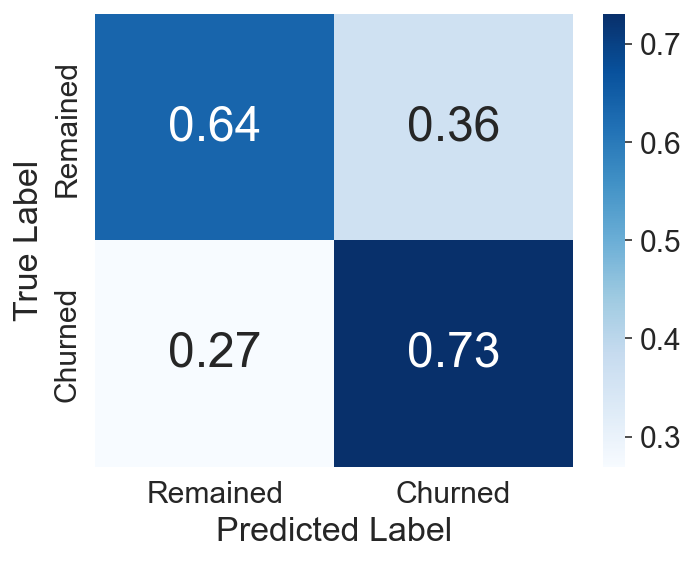

In [29]:
lr = LogisticRegression(random_state = random_state)

param_grid = {'max_iter' : [100],
              'penalty' : ['l1', 'l2'],
              'C' : [0.001, 0.01, 0.1, 1, 10],
              'solver' : ['lbfgs', 'liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, scoring = scoring_metric, 
                      cv = 5, verbose = False, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train, y_train)
clf_performance(best_clf_lr, 'Logistic Regression', 'LR')

Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      gamma: scale
      kernel: rbf


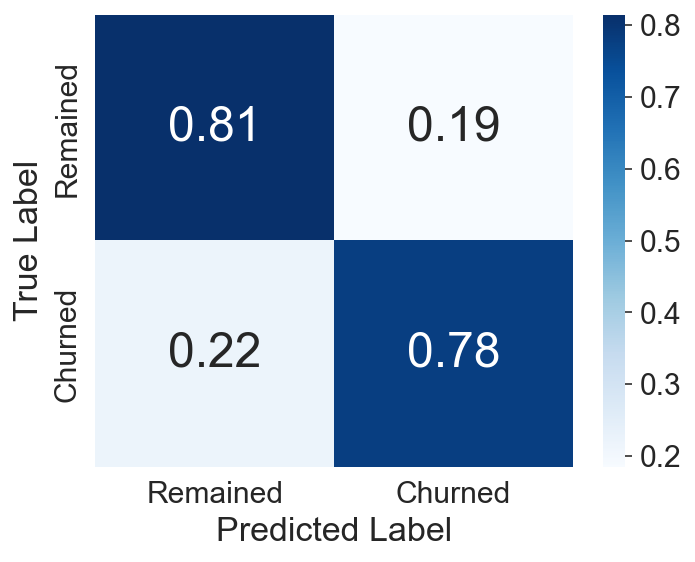

In [30]:
svc = SVC(probability = True, random_state = random_state)
param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'], 
                                  'C': [.1, 1, 10]}]

clf_svc = GridSearchCV(svc, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train, y_train)
clf_performance(best_clf_svc, 'Support Vector Classifier', 'SVC')

Random Forest


 Random Forest Classifier
-------------------------------
   Best Score (recall): 0.772
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 2
      n_estimators: 50


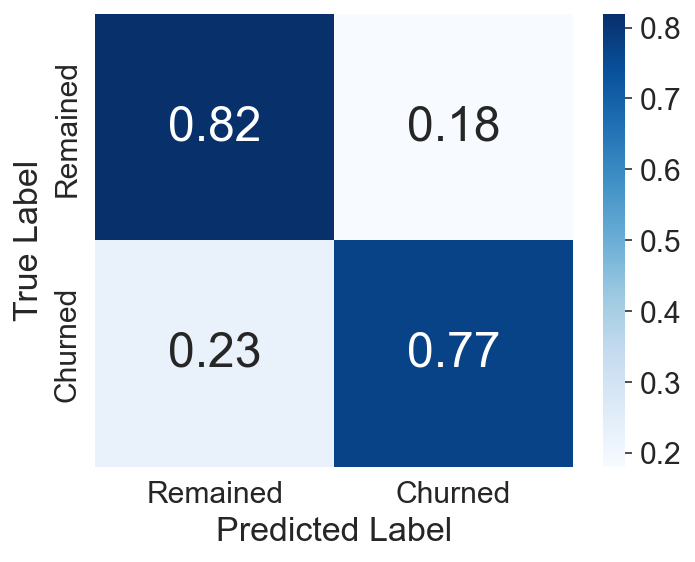

In [31]:
rf = RandomForestClassifier(random_state = random_state)
param_grid = {'n_estimators': [50],
              'criterion': ['entropy', 'gini'],
              'bootstrap': [True],
              'max_depth': [6],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [2, 3, 5],
              'min_samples_split': [2, 3, 5]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train, y_train)
clf_performance(best_clf_rf, 'Random Forest Classifier', 'RF')

Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


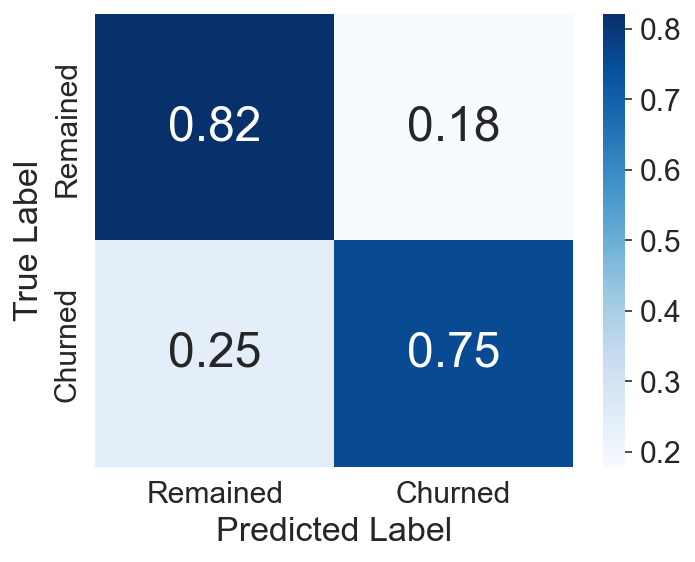

In [32]:
gbc = GradientBoostingClassifier(random_state = random_state)
param_grid = {'n_estimators': [600],
              'subsample': [0.66, 0.75],
              'learning_rate': [0.001, 0.01],
              'max_depth': [3],                       # default=3
              'min_samples_split': [5, 7],
              'min_samples_leaf': [3, 5],
              'max_features': ['auto', 'log2', None],
              'n_iter_no_change': [20],
              'validation_fraction': [0.2],
              'tol': [0.01]}
                                  
clf_gbc = GridSearchCV(gbc, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_gbc = clf_gbc.fit(X_train, y_train)
clf_performance(best_clf_gbc, 'Gradient Boosting Classifier', 'GBC')

The number of estimators after early stopping is:

In [33]:
best_clf_gbc.best_estimator_.n_estimators_

284

XGBoost Classifier

C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.785
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.001
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75
[17:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ubjd\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


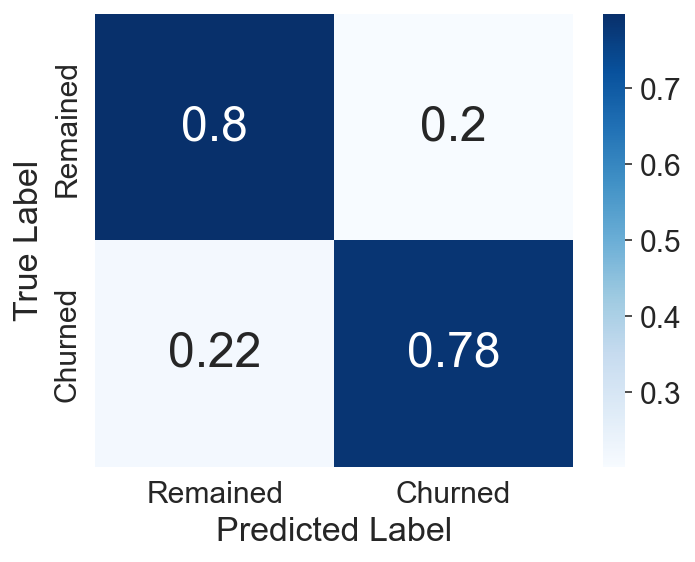

In [34]:
xgb = XGBClassifier(random_state = random_state)

param_grid = {'n_estimators': [50],
              'learning_rate': [0.001, 0.01],
              'max_depth': [3, 4],                # default=6
              'reg_alpha': [1, 2],
              'reg_lambda': [1, 2],
              'subsample': [0.5, 0.75],
              'colsample_bytree': [0.50, 0.75],
              'gamma': [0.1, 0.5, 1],
              'min_child_weight': [1]}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train, y_train)
clf_performance(best_clf_xgb, 'XGBoost Classifier', 'XGBC')

LGBMClassifier

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.779
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.1
      reg_lambda: 0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


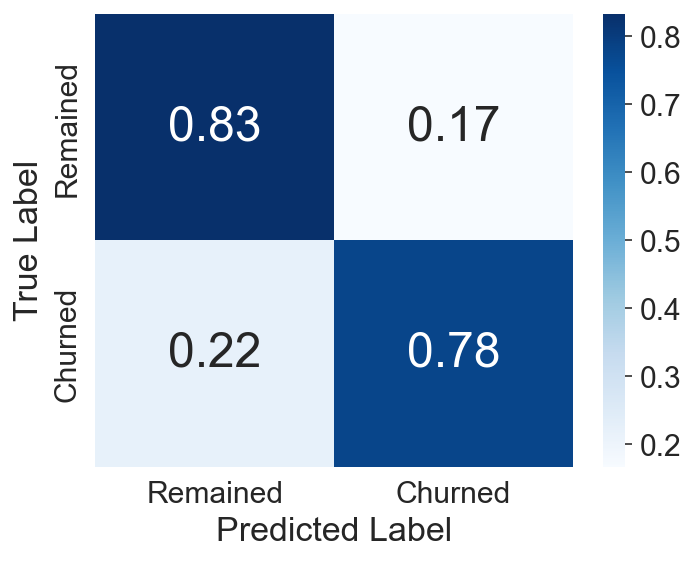

In [35]:
lgbmc = LGBMClassifier(random_state = random_state)

param_grid = {'max_depth': [5],
              'num_leaves': [5, 10],
              'learning_rate': [0.001, 0.01],
              'n_estimators': [200],
              'feature_fraction': [0.5],
              'min_child_samples': [5, 10],
              'reg_alpha': [0.1, 0.5],
              'reg_lambda': [0.1, 0.5]} 

clf_lgbmc = GridSearchCV(lgbmc, param_grid = param_grid, verbose = False,
                         scoring = scoring_metric, cv = 5, n_jobs = -1)

best_clf_lgbmc = clf_lgbmc.fit(X_train, y_train)
clf_performance(best_clf_lgbmc, 'LGBMClassifier', 'LGBMC')

Ensemble Learning

Soft Voting
-----------------
  Recall:  0.785


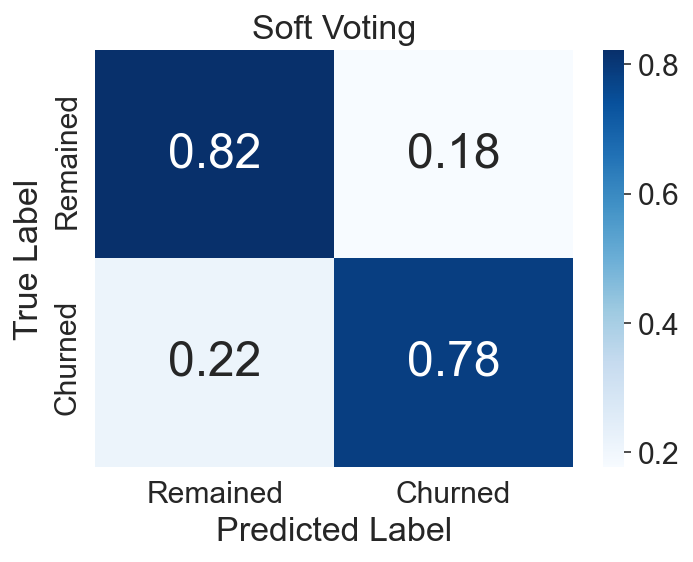

In [36]:
estimators = [('LR', best_clf_lr.best_estimator_),
              ('SCV', best_clf_svc.best_estimator_),
              ('RF', best_clf_rf.best_estimator_),
              ('GBC', best_clf_gbc.best_estimator_),
              ('XGB', best_clf_xgb.best_estimator_),
              ('LGBMC', best_clf_lgbmc.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators = estimators[1:], voting = 'soft', n_jobs = -1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize = 'true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [accuracy_score(y_train, y_pred),
                           precision_score(y_train, y_pred),
                           recall_score(y_train, y_pred),
                           roc_auc_score(y_train, y_pred_pp), fpr, tpr]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, ax = plt.subplots(figsize = (5, 4))

plot_conf_mx(cm, 'Soft Voting', ax)    
plt.tight_layout();

Learning Curves

Learning curves are plots of a model’s performance on the training set and the validation set as a function of the training set size. They can help us visualise overfitting/underfitting and the effect of the training size on a model's error.

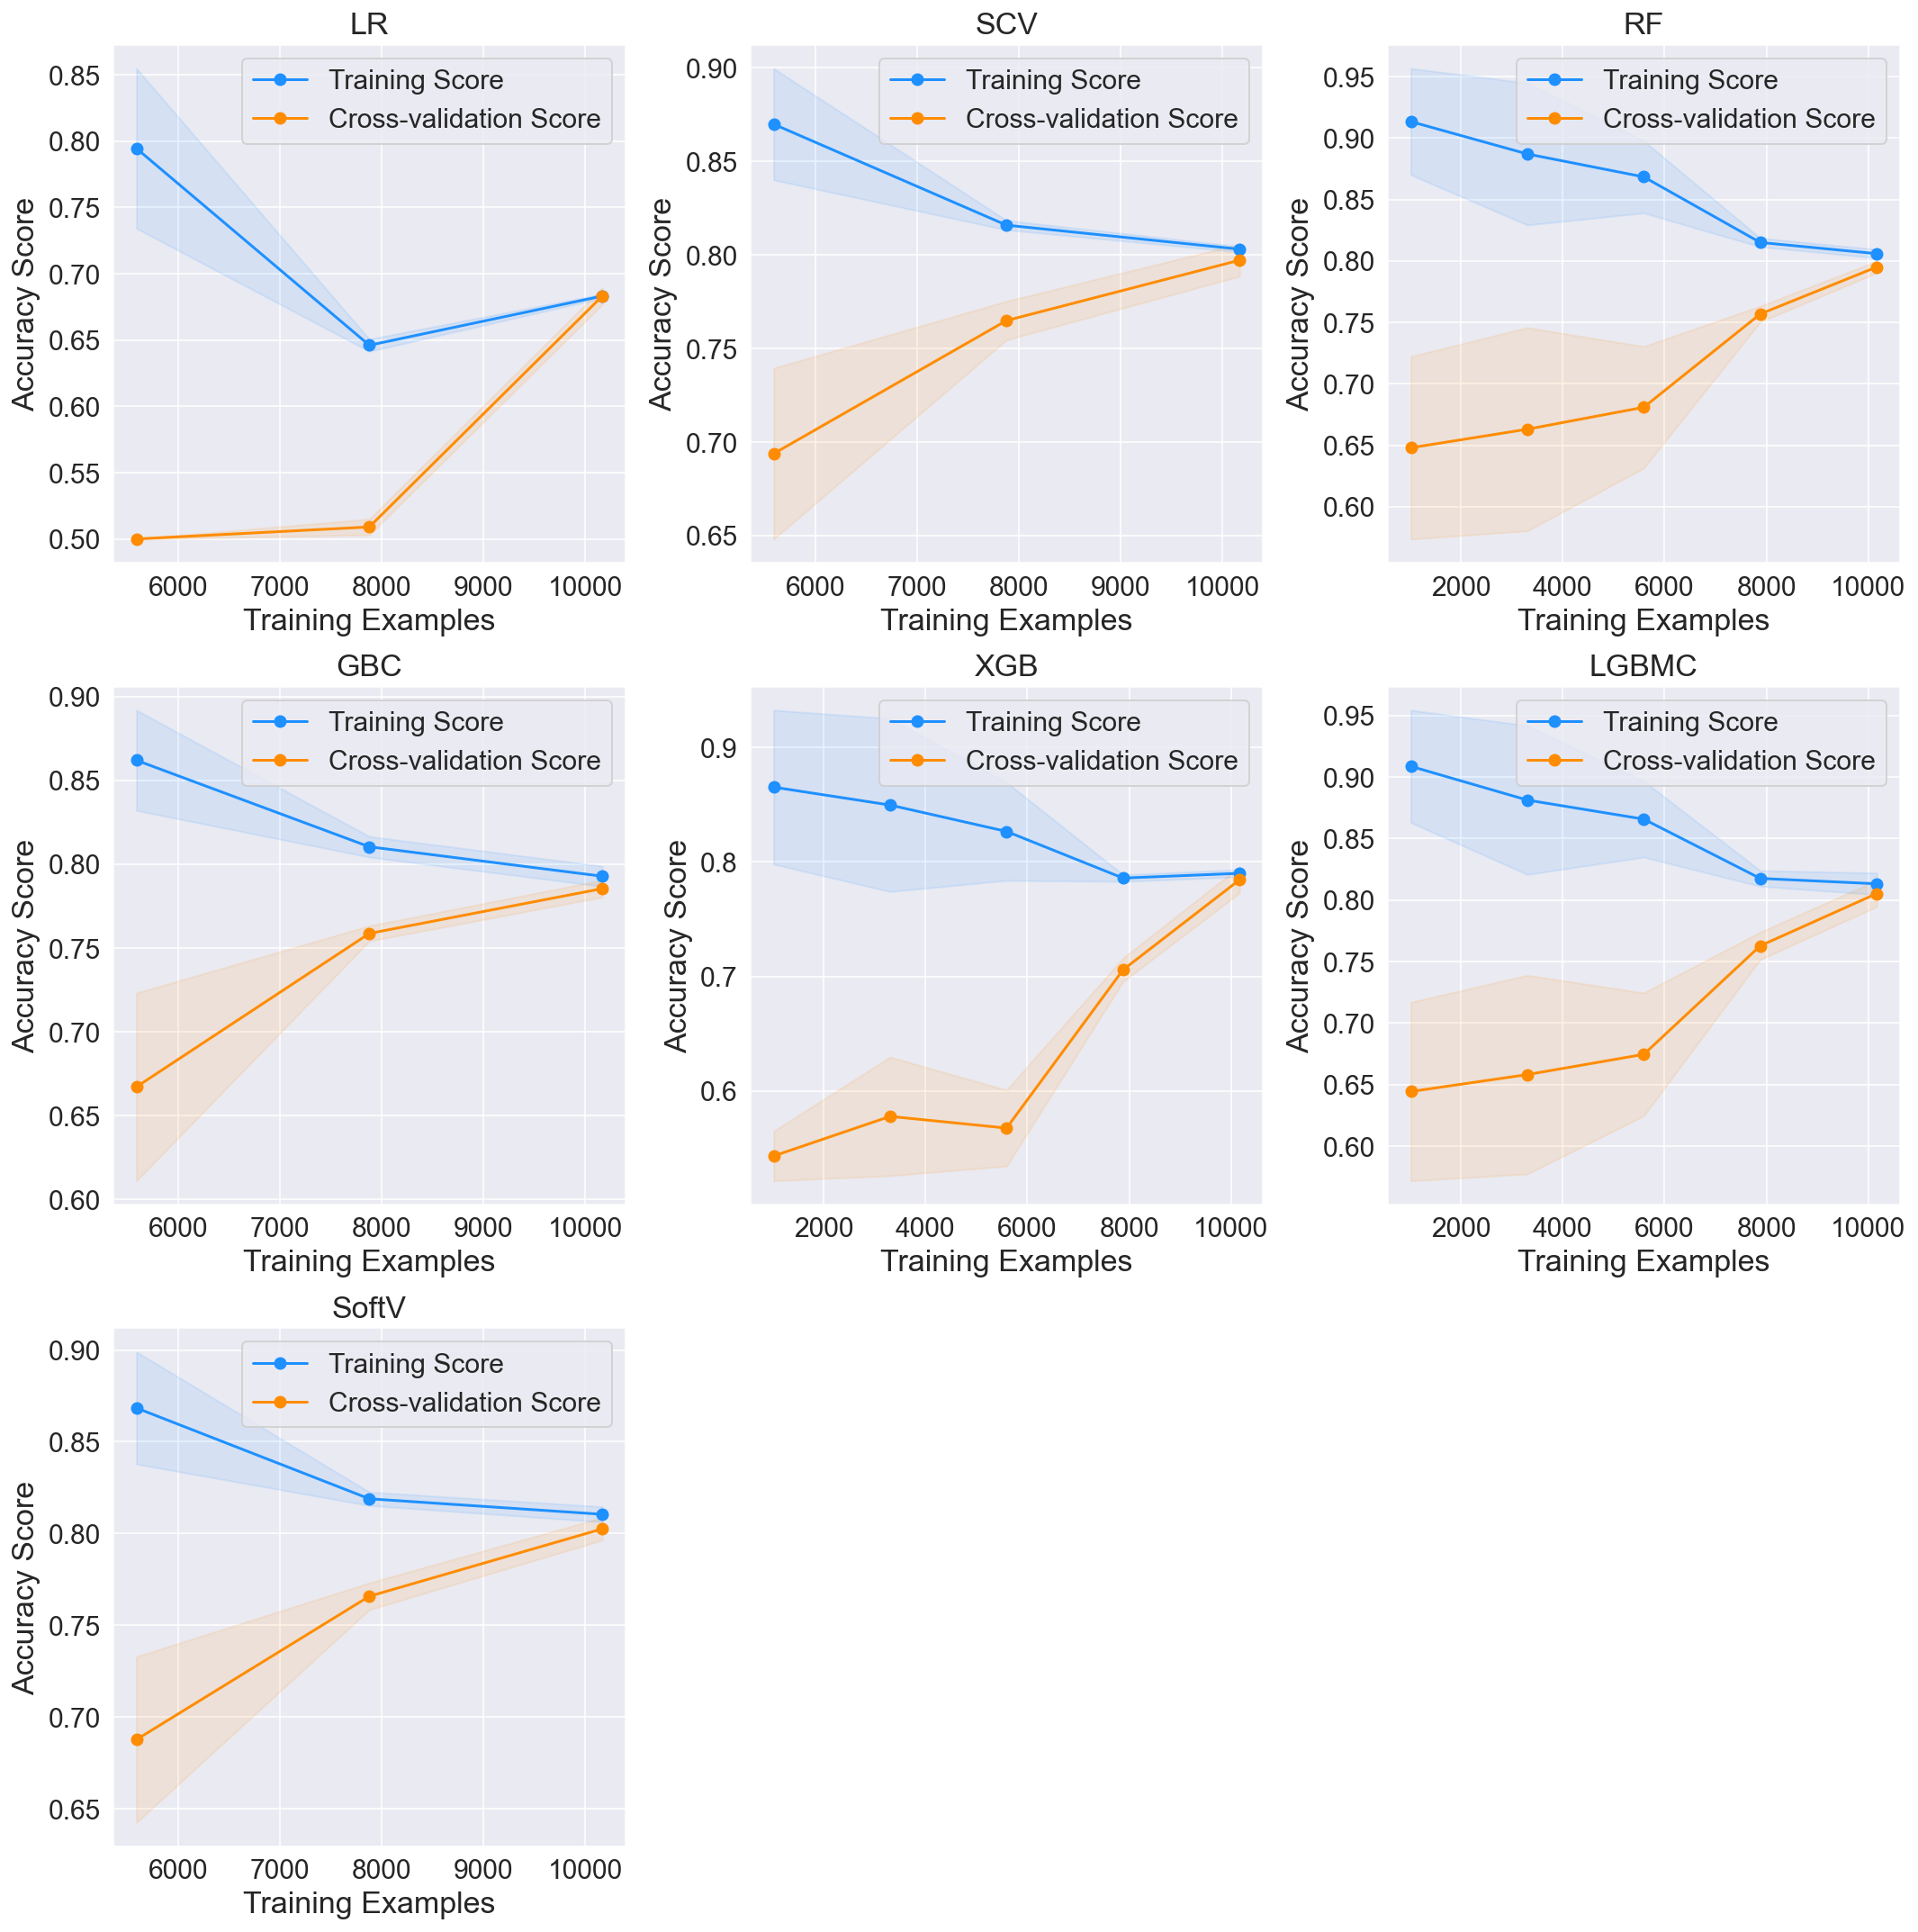

In [37]:
fig, ax = plt.subplots(3, 3, figsize = (15, 15))

for i in range(len(estimators)):
    plt.subplot(3, 3, i + 1)
    plot_learning_curve(estimators[i][1], estimators[i][0], X_train, y_train)
    
plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off();

For all models, there is a tiny gap between the two curves at the end of training. This indicates that we do not overfit the training set.

Some classifiers allow us to visualise feature importance:

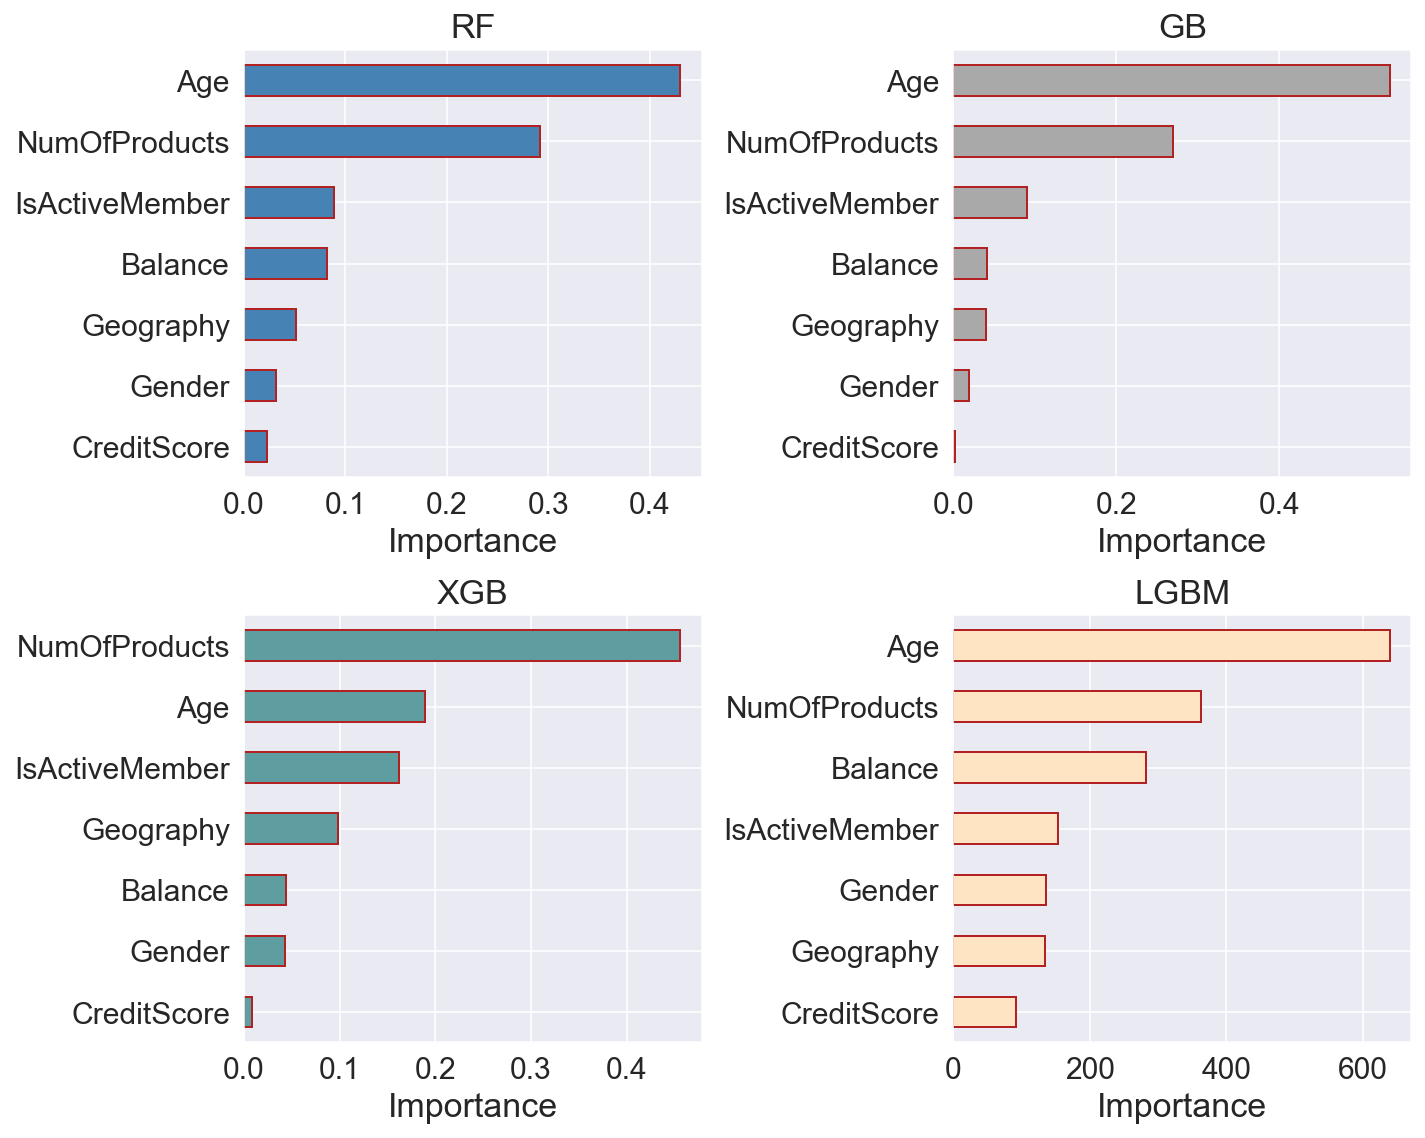

In [38]:
color_ = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize = (10, 8))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'], 
                                    [best_clf_rf, best_clf_gbc, best_clf_xgb, best_clf_lgbmc])):
    
    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, color_[i], ax)
    plt.ylabel('')
    
plt.tight_layout();

'Age' and 'NumOfProducts' seem like the most useful features for all classifiers, followed by 'IsActiveMember' and 'Balance'. On the other hand, 'CreditScore' is the least important feature with a small value close to zero for all estimators apart from LGBM.

we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall, and area under the ROC curve or simply AUC):

In [39]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix, index = ['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color = 'indianred', axis = 0)

,Accuracy,Precision,Recall,AUC
LR,0.683,0.667,0.730,0.734
SVC,0.797,0.808,0.780,0.876
RF,0.796,0.810,0.772,0.882
GBC,0.788,0.808,0.755,0.875
XGBC,0.791,0.795,0.785,0.875
LGBMC,0.806,0.823,0.779,0.888
SVot,0.803,0.815,0.785,0.887


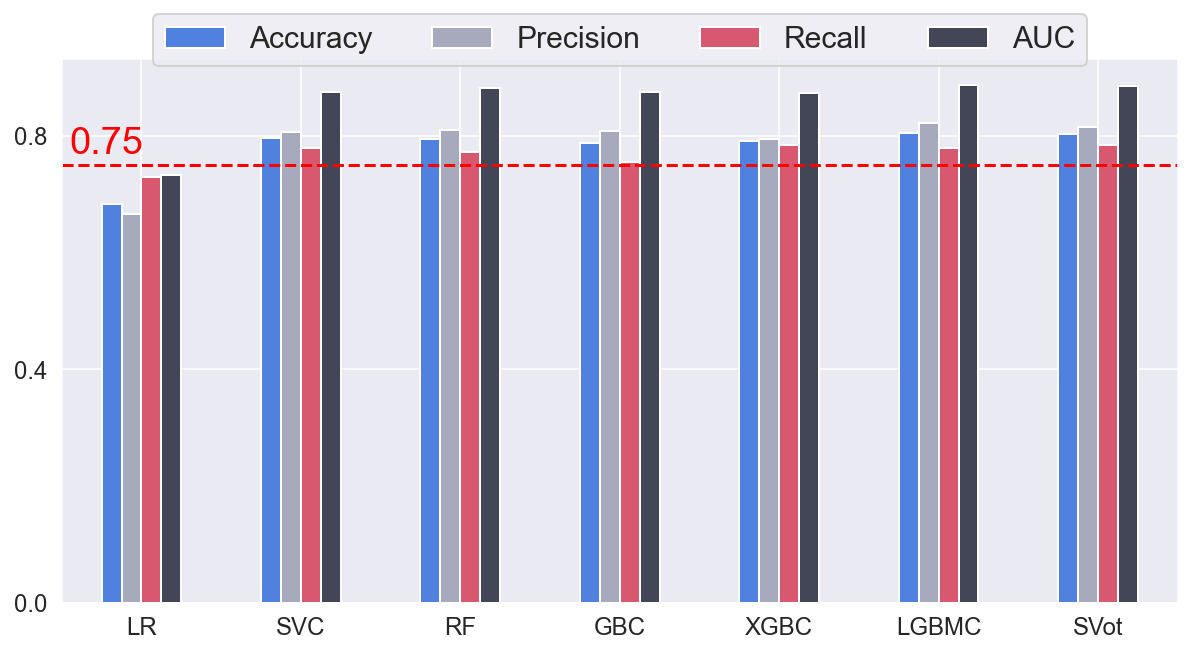

In [40]:
comparison_df.plot(kind = 'bar', figsize = (10, 5), fontsize = 12, color = ['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc = 'upper center', ncol = len(comparison_df.columns), bbox_to_anchor = (0.5, 1.11))
plt.xticks(rotation = 0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y = 0.75, color = 'red', linestyle = '--')
plt.text(x = -0.45, y = 0.77, s = '0.75', size = label_size + 2, color = 'red');


Apart from LR, all other classifiers have a recall higher than 75%. The Soft Voting classifier is the model with the highest recall (78.5 %). However, the LGBM classifier has the best overall performance with the highest accuracy, precision, and AUC.

Using single metrics is not the only way of comparing the predictive performance of classification models. The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classifier at different classification thresholds. It plots the true positive rate (another name for recall) against the false positive rate.


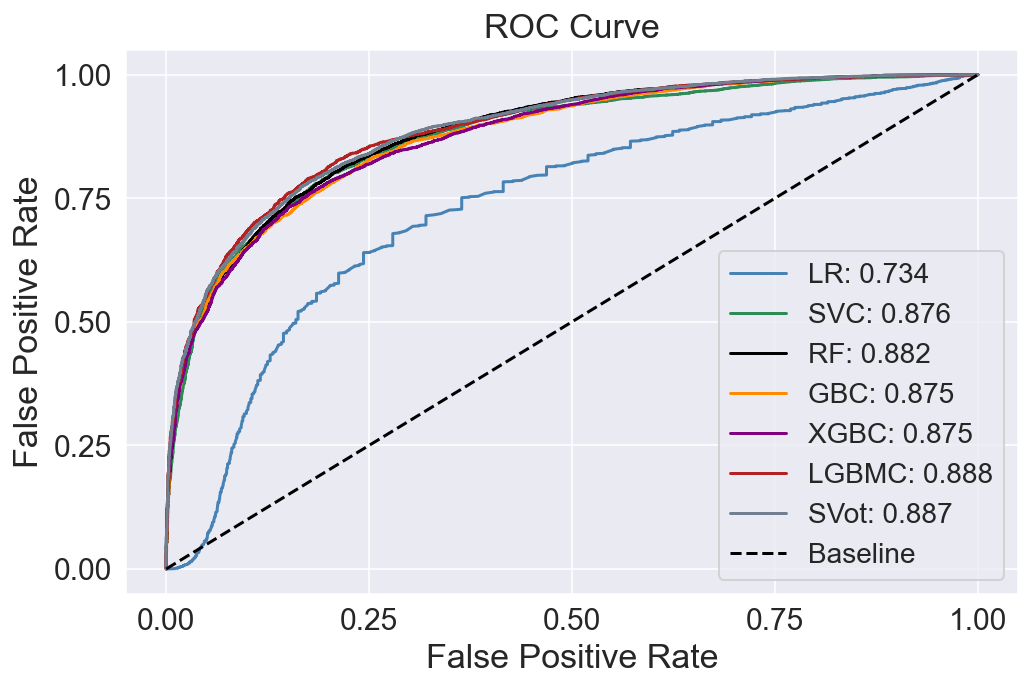

In [41]:
colors = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

fig = plt.figure(figsize = (8, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    plt.plot(fpr, tpr, color = colors[index], label = '{}: {}'.format(key, np.round(auc, 3)))

plt.plot([0, 1], [0, 1], 'k--', label = 'Baseline')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('False Positive Rate')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.legend(fontsize = 14);


The dashed diagonal line represents a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In our case, all classifiers, apart from Logistic Regression, perform similarly. It seems that LGBM performs marginally better as evidenced by the slightly higher AUC (0.888).


The scikitplot library offers an easy way of plotting this chart:

Soft Voting:


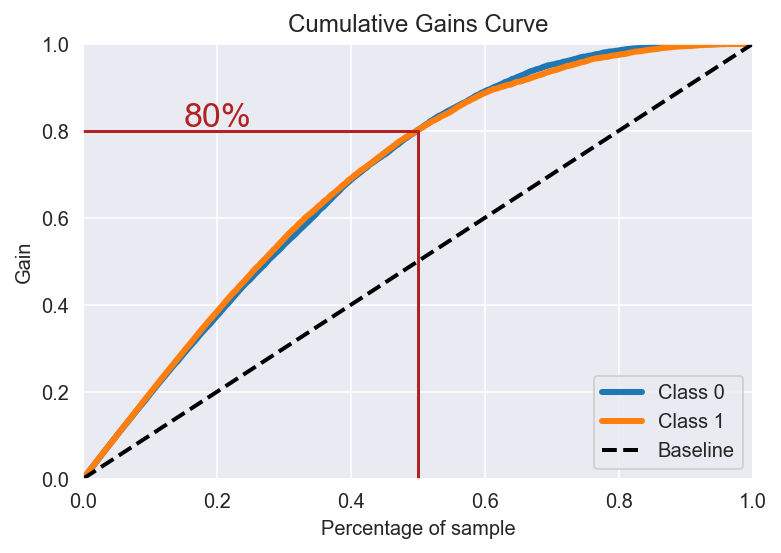

In [42]:
print ('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft, X_train, y_train, cv = 5, method = 'predict_proba')
skplt.metrics.plot_cumulative_gain(y_train, y_pred)

plt.plot([0.5, 0.5], [0, 0.8], color = 'firebrick')
plt.plot([0.0, 0.5], [0.8, 0.8], color = 'firebrick')
plt.text(0.15, 0.81, '80%', size = label_size, color = 'firebrick');

This chart shows that if we target 50% of the customers most likely to churn (according to the model), the model will pick 80% of customers who will actually churn, while the random pick would pick only 50% of the targets.

Evaluating the Test Set

In [43]:
test_df.drop(features_drop, axis = 1, inplace = True)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({'Germany': 1, 'Spain': 0, 'France': 0})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

print ('Preprocessing completed!')

Preprocessing completed!


We will use the same method for comparing our classifiers as we did in the training set.

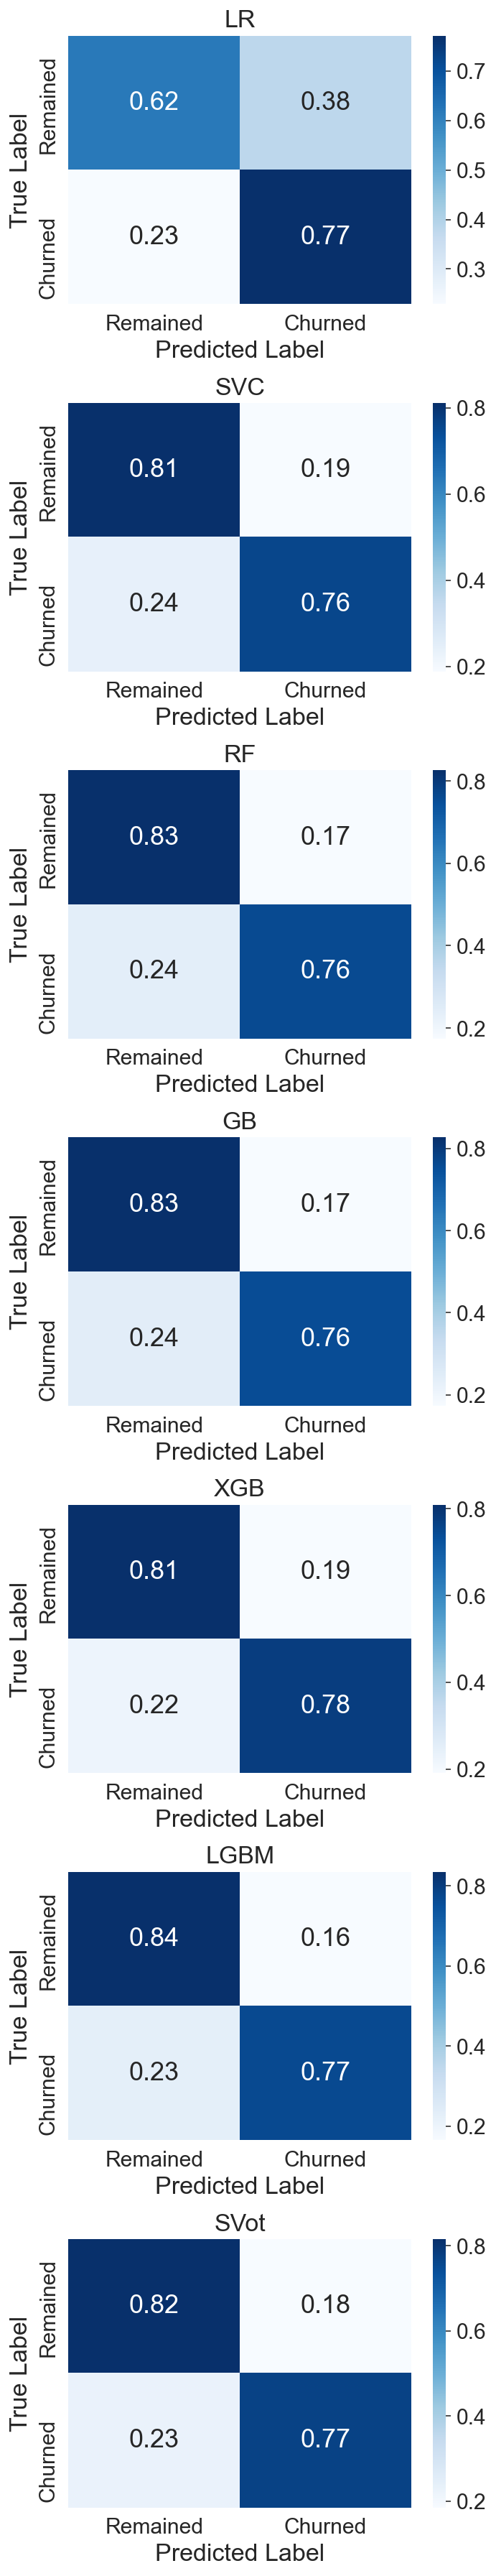

In [44]:
tuned_voting_soft.fit(X_train, y_train)
fig = plt.subplots(7, 1, figsize = (5, 25))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'],
                                    [best_clf_lr.best_estimator_, best_clf_svc.best_estimator_, best_clf_rf.best_estimator_, best_clf_gbc.best_estimator_, best_clf_xgb.best_estimator_, best_clf_lgbmc.best_estimator_, tuned_voting_soft])):
    
    plt.subplot(7, 1, i + 1)
    test_func(clf, name)
    
plt.tight_layout();

In [45]:
comparison_test_df = pd.DataFrame(comparison_test_dict, index = ['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color = 'indianred', axis = 0)

,Accuracy,Precision,Recall
LR,0.650,0.332,0.771
SVC,0.801,0.496,0.758
RF,0.813,0.516,0.761
GB,0.812,0.516,0.756
XGB,0.802,0.498,0.776
LGBM,0.823,0.533,0.771
SVot,0.806,0.505,0.771


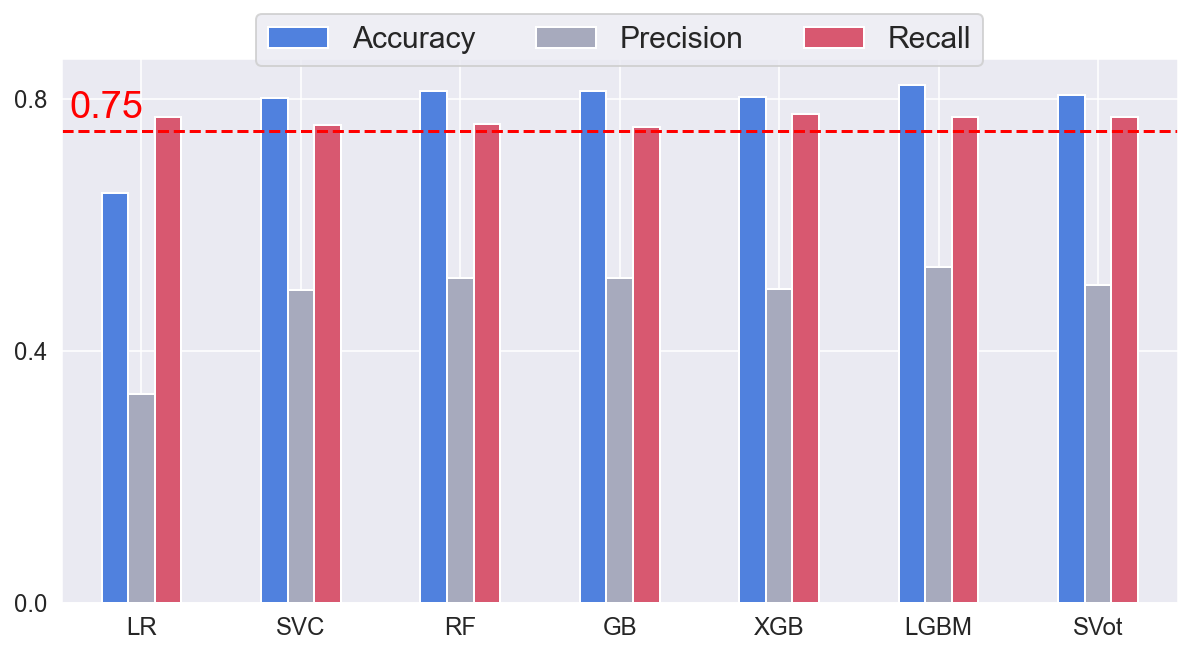

In [46]:
comparison_test_df.plot(kind = 'bar', figsize = (10, 5), fontsize = 12, color = ['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc = 'upper center', ncol = len(comparison_test_df.columns), bbox_to_anchor = (0.5, 1.11))
plt.xticks(rotation = 0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y = 0.75, color = 'red', linestyle = '--')
plt.text(x = -0.45, y = 0.77, s = '0.75', size = label_size + 2, color = 'red');


There are two main points we need to note:

1) The last three estimators (XGB, LGBM, and Soft Voting) seem like the best options as they display a high recall (around 77.1%). LGBM has the highest accuracy, precision, and recall. However, small variations are expected due to the small size of the test set and LGBM's performance is not significantly different than XGB and Soft Voting.

2) Performance on the test set is fairly similar to the training set which proves that we do not have a problem with overfitting.


Conclusions


    EDA can help us identify which features contribute to customer churn. Additionally, feature importance analysis can quantify the importance of each feature in predicting the likelihood of churn. Our results reveal that the most significant feature is age (older customers are more likely to churn), followed by the number of products (having more products increases a customer’s likelihood to churn). The bank could use our findings to adapt and improve its services in a way that increases satisfaction for those customers more likely to churn.

    We can build several machine learning models with recall approximately equal to 78%. Perhaps, adding more features or/and records could help us improve predictive performance.
